# **Perhitungan Manual PageRank**
PageRank adalah algoritma yang digunakan oleh mesin pencari Google untuk memberikan peringkat pada halaman-halaman web dalam hasil pencarian. Algoritma ini dikembangkan oleh Larry Page dan Sergey Brin, pendiri Google, dan dinamai dari nama Larry Page.

Tujuan utama PageRank adalah mengukur seberapa penting atau otoritatif sebuah halaman web dengan mempertimbangkan struktur tautan antar halaman-halaman tersebut. Ide dasar di balik PageRank adalah bahwa halaman web yang banyak dihubungkan oleh halaman-halaman lain memiliki tingkat otoritas yang lebih tinggi.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install sastrawi

In [4]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re
import joblib
import string

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import pandas as pd
path = '/content/drive/MyDrive/ppw/latihan/dataset/berita_suara_label_fiks.csv'
data = pd.read_csv(path, delimiter=';')
data

,Judul_Artikel,Content_Artikel,Category
0,\n MedcoEnergi Membangu...,Suara.com - PT Medco Energi Internasional Tbk ...,Bisnis
1,\n Sekjen Kemnaker Temu...,Suara.com - Sekretaris Jenderal (Sekjen) Kemen...,Bisnis
2,\n Bertemu Pimpinan Per...,Suara.com - Sebagai langkah pertukaran informa...,Bisnis
3,\n Inovasi Pertamina EP...,Suara.com - Pola pertanian tradisional dengan ...,Bisnis
4,\n Ayo Cermat Sebelum T...,Suara.com - Waspada! Modus penipuan yang menga...,Bisnis
...,...,...,...
835,\n Fuji Ditransfer Duit...,Suara.com - Selebgram Fujianti Utami alias Fuj...,Entertainment
836,\n Yuni Shara Bikin Vid...,Suara.com - Yuni Shara dikenal sebagai salah s...,Entertainment
837,\n Direkam Sandy Pas Ba...,Suara.com - Sandy Pas Band mengunggah foto kom...,Entertainment
838,"\n Bukan TBC, Terungkap...","Suara.com - Ibunda musisi Virgoun, Eva Manurun...",Entertainment


In [6]:
# Hitung jumlah kelas
kelas = data['Category'].value_counts()
kelas

Bisnis           280
Sports           280
Entertainment    280
Name: Category, dtype: int64

In [7]:
data.isnull().sum()

Judul_Artikel      0
Content_Artikel    0
Category           0
dtype: int64

In [8]:
data.duplicated().sum()

0

### Clean data

In [9]:
# membuat kolom baru dengan nama new_abstrak untuk data baru yang dipunctuation
data['clean_content'] = data['Content_Artikel'].str.replace('[{}]'.format(string.punctuation), '').str.lower()

# Menghilangkan angka dari kolom 'new_abstrak'
data['clean_content'] = data['clean_content'].str.replace('\d+', '', regex=True)
data['clean_content']

0      suaracom  pt medco energi internasional tbk me...
1      suaracom  sekretaris jenderal sekjen kementeri...
2      suaracom  sebagai langkah pertukaran informasi...
3      suaracom  pola pertanian tradisional dengan pe...
4      suaracom  waspada modus penipuan yang mengatas...
                             ...                        
835    suaracom  selebgram fujianti utami alias fuji ...
836    suaracom  yuni shara dikenal sebagai salah sat...
837    suaracom  sandy pas band mengunggah foto komed...
838    suaracom  ibunda musisi virgoun eva manurung s...
839    suaracom  shindy samuel menjalani prosedur kec...
Name: clean_content, Length: 840, dtype: object

### Tokenizing

In [10]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Download kamus stop words
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

data["tokenizing"] = data['clean_content'].apply(tokenizer)
data["tokenizing"]

0      [suaracom  pt medco energi internasional tbk m...
1      [suaracom  sekretaris jenderal sekjen kementer...
2      [suaracom  sebagai langkah pertukaran informas...
3      [suaracom  pola pertanian tradisional dengan p...
4      [suaracom  waspada modus penipuan yang mengata...
                             ...                        
835    [suaracom  selebgram fujianti utami alias fuji...
836    [suaracom  yuni shara dikenal sebagai salah sa...
837    [suaracom  sandy pas band mengunggah foto kome...
838    [suaracom  ibunda musisi virgoun eva manurung ...
839    [suaracom  shindy samuel menjalani prosedur ke...
Name: tokenizing, Length: 840, dtype: object

### Ekstraksi Kata Kunci

In [12]:
corpus = data["tokenizing"][0]
corpus

['suaracom  pt medco energi internasional tbk medcoenergi telah lama menjadi pelopor dalam industri energi di indonesia dan mereka terus berkomitmen untuk membangun bisnis berkelanjutan yang memperhatikan tanggung jawab lingkungan dan dampak perubahan iklim perusahaan ini telah memahami bahwa pemanasan global adalah masalah serius yang perlu diatasi dan mereka ingin berkontribusi positif terhadap upaya penanggulangan perubahan iklim medcoenergi berusaha memanfaatkan sumberdaya alam yang ada secara bertanggung jawab sehingga lingkungan hidup di sekitarnya senantiasa terjaga mereka yakin bahwa kelangsungan bisnis medcoenergi dapat dipertahankan untuk generasi yang akan datang sekaligus mendukung upaya pemerintah indonesia dalam menghadapi pemanasan global akibat perubahan iklim medcoenergi melakukan pendekatan terhadap keberkelanjutan bisnis dengan berpedoman pada tiga pilar utama kepemimpinan dari dan oleh pekerja kami pengembangan sosial dan lingkungan hidup serta pemberdayaan masyarak

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from nltk.tokenize import word_tokenize
def build_co_occurrence_matrix(corpus,window_size):
    #build unique words
    unique_words=set()
    for text in corpus:
        for word in word_tokenize(text):
            unique_words.add(word)

    word_search_dict={word:np.zeros(shape=(len(unique_words))) for word in unique_words}
    word_list=list(word_search_dict.keys())
    for text in corpus:
        text_list=word_tokenize(text)
        for idx,word in enumerate(text_list):
            #pick word in the size range
            i=max(0,idx-window_size)
            j=min(len(text_list)-1,idx+window_size)
            search=[text_list[idx_] for idx_ in range(i,j+1)]
            search.remove(word)
            for neighbor in search:
                # get neighbor idx in word_search_dict
                nei_idx=word_list.index(neighbor)
                word_search_dict[word][nei_idx]+=1
    return word_search_dict

In [15]:
coo_dict=build_co_occurrence_matrix(corpus,window_size=1)
coo_dict

{'menjadi': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'medco': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [16]:
co_occurrence_matrix = pd.DataFrame(coo_dict,index=coo_dict.keys()).astype('int')
co_occurrence_matrix

,menjadi,medco,merupakan,mereka,pt,hilmi,stabil,positif,dampak,lama,...,masa,sumberdaya,lupa,strategi,berusaha,barel,hal,yang,sosial,pilar
menjadi,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
medco,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
merupakan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mereka,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pt,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
barel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yang,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sosial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
a = co_occurrence_matrix.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
a

,source,target,weight
0,menjadi,lama,1
1,menjadi,untuk,1
2,menjadi,pelopor,2
3,medco,pt,1
4,medco,energi,1
...,...,...,...
699,yang,ambisius,1
700,sosial,dan,1
701,sosial,pengembangan,1
702,pilar,tiga,1


In [18]:
# Menghitung matriks co-occurrence dengan CountVectorizer
vectorizer = CountVectorizer()
co_occurrence_matrix = vectorizer.fit_transform(corpus).T * vectorizer.fit_transform(corpus)

# Membuat DataFrame dari matriks co-occurrence
df_co_occurrence = pd.DataFrame(co_occurrence_matrix.toarray(), columns=vectorizer.get_feature_names_out(),index=vectorizer.get_feature_names_out())

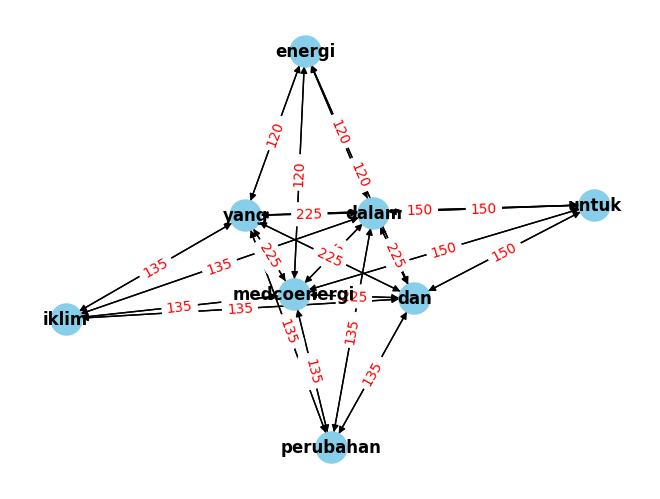

In [25]:
G = nx.DiGraph()  # Menggunakan Directed Graph agar panah dapat ditampilkan

# Membuat graf dengan edge untuk nilai yang memenuhi kondisi
for idx, row in df_co_occurrence.iterrows():
    for col in df_co_occurrence.columns:
        weight = df_co_occurrence.loc[idx, col]
        if weight > 110 and idx != col:
            G.add_edge(idx, col, weight=weight)

pos = nx.spring_layout(G)  # Penataan node

# Menggambar grafik dengan label edge dan panah
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_color='red')

plt.show()

## **Hitung Manual PageRank**
**Rumus :**
$$
PR(u) = (1-d) . \frac{1}{N} + d . \sum_{v∈Bu} \frac{PR(v)}{L(v)}
$$


KETERANGAN:
- ( PR(u) ) adalah PageRank dari halaman ( u ).
- ( d ) adalah damping factor, biasanya diatur sebagai 0.85.
- ( N ) adalah jumlah total halaman dalam graf (jumlah node dalam graf).
- ( B_u ) adalah himpunan halaman yang memiliki tautan ke halaman ( u ).
- ( L(v) ) adalah jumlah tautan keluar dari halaman ( v )."

In [30]:
df = pd.read_excel('/content/drive/MyDrive/ppw/latihan/dataset/hitung_manual_pagerank_kata_ARSY.xlsx')
df_filled = df.fillna('')
df_filled

,ITERASI,kata,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,,dalam,dan,medcoenergi,yang,untuk,iklim,perubahan,energi,,,,,
1,1,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,,,,,"DEFAULT DAMPING FACTOR = 0,85"
2,2,0.105485,0.105485,0.105485,0.105485,0.053444,0.053444,0.053444,0.053444,,,,,
3,3,0.102604,0.102604,0.102604,0.102604,0.069985,0.069985,0.069985,0.069985,,,,,
4,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,
6,kata,IN,OUT,,ITERASI 2,ITERASI 3,,,,,,,,
7,dalam,7,7,,0.102041,0.098652,,,,,,,,
8,dan,7,7,,0.102041,0.098652,,,,,,,,
9,medcoenergi,7,7,,0.102041,0.098652,,,,,,,,


## **PageRank Coding**

In [26]:
# Hitung centrality pada berita 1 dengan PageRank
centrality = nx.pagerank(G)
# Ubah ke dalam dataframe
pagerank_df = pd.DataFrame(list(centrality.items()), columns=['Kata', 'Pagerank Centrality'])
pagerank_df = pagerank_df.sort_values(by='Pagerank Centrality', ascending=False)
pagerank_df

,Kata,Pagerank Centrality
0,dalam,0.167843
1,dan,0.167843
4,medcoenergi,0.167843
7,yang,0.167843
6,untuk,0.089202
3,iklim,0.082157
5,perubahan,0.082157
2,energi,0.075112


## **Clossenes Centrality**

In [27]:
# Hitung centrality pada berita 1 dengan closeness
closeness_centrality = nx.closeness_centrality(G)
# Ubah ke dalam dataframe
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Kata', 'Closeness Centrality'])
closeness_df = closeness_df.sort_values(by='Closeness Centrality', ascending=False)
closeness_df

,Kata,Closeness Centrality
0,dalam,1.0
1,dan,1.0
4,medcoenergi,1.0
7,yang,1.0
2,energi,0.7
3,iklim,0.7
5,perubahan,0.7
6,untuk,0.7


In [28]:
# Mengurutkan peringkat kata-kata berdasarkan centrality
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Buat dataframe dari hasil peringkat
df = pd.DataFrame(sorted_centrality, columns=['Kata', 'Centrality'])

# Tambahkan kolom peringkat
df['Peringkat'] = df['Centrality'].rank(ascending=False).astype(int)

df

,Kata,Centrality,Peringkat
0,dalam,0.167843,2
1,dan,0.167843,2
2,medcoenergi,0.167843,2
3,yang,0.167843,2
4,untuk,0.089202,5
5,iklim,0.082157,6
6,perubahan,0.082157,6
7,energi,0.075112,8


In [29]:
# Mengambil lima kata teratas
top_5_words = sorted_centrality[:5]

# Membuat DataFrame dari lima kata teratas
top_5_df = pd.DataFrame(top_5_words, columns=['Kata', 'Centrality'])
top_5_df

,Kata,Centrality
0,dalam,0.167843
1,dan,0.167843
2,medcoenergi,0.167843
3,yang,0.167843
4,untuk,0.089202
